In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import h5py
import numpy as np
from matplotlib.colors import LogNorm

Each file is a collection of 500,000 (or 400,000 in the case of positrons) calorimeter showers corresponding to the particle specified in the file name (eplus = positrons, gamma = photons, piplus = charged pions). 

The calorimeter we built is segmented longitudinally into three layer with different depths and granularities. In units of mm, the three layers have the following (eta, phi, z) dimensions:
Layer 0: (5, 160, 90) | Layer 1: (40, 40, 347) | Layer 2: (80, 40, 43)

In the HDF5 files, the `energy` entry specifies the true energy of the incoming particle in units of GeV. `layer_0`, `layer_1`, and `layer_2` represents the energy deposited in each layer of the calorimeter in an image data format. Given the segmentation of each calorimeter layer, these images have dimensions 3x96 (in layer 0), 12x12 (in layer 1), and 12x6 (in layer 3). The `overflow` contains the amount of energy that was deposited outside of the calorimeter section we are considering. The fields `x0`, `y0`, `z0`, `t0`, `px`, `py`, `pz` provide position and kinematic information of incident particles upon impact. 

In [2]:
path = "./data"
filename_e = 'eplus_angle_position_5deg_xy.h5'
# filename_gamma = 'gamma_angle_position_5deg_xy.h5'
# filename_pi = 'piplus_angle_position_5deg_xy.h5'

In [3]:
data_e = h5py.File(os.path.join(path,filename_e),'r')

In [4]:
data_e.keys()

<KeysViewHDF5 ['energy', 'layer_0', 'layer_1', 'layer_2', 'overflow', 'px', 'py', 'pz', 't0', 'x0', 'y0', 'z0']>

In [5]:
#create a class to hold the data 
class ParticleData:
    def __init__(self, data):
        self.energy = np.array(data['energy'])
        self.energy = np.array(data['energy'])
        self.layer_0 = np.array(data['layer_0'])
        self.layer_1 = np.array(data['layer_1'])
        self.layer_2 = np.array(data['layer_2'])
        self.px,self.py,self.pz = np.array(data['px']),np.array(data['py']),np.array(data['pz'])
        self.x0,self.y0,self.z0 = np.array(data['x0']),np.array(data['y0']),np.array(data['z0'])
    
    def check_for_nulls_and_infs(self):
        issues = {}
        for attr_name in vars(self):
            attr = getattr(self, attr_name)
            if isinstance(attr, np.ndarray):
                nan_count = np.isnan(attr).sum()
                inf_count = np.isinf(attr).sum()
                if nan_count > 0 or inf_count > 0:
                    issues[attr_name] = {
                        'nan_count': int(nan_count),
                        'inf_count': int(inf_count)
                    }
            elif attr is None:
                issues[attr_name] = {'none': True}
        return issues

In [6]:
particle_data = ParticleData(data_e)
# data_gamma = ParticleData(data_gamma)
# data_pi = ParticleData(data_pi)

In [7]:
particle_data.check_for_nulls_and_infs()

{}

## Data Visuzalization

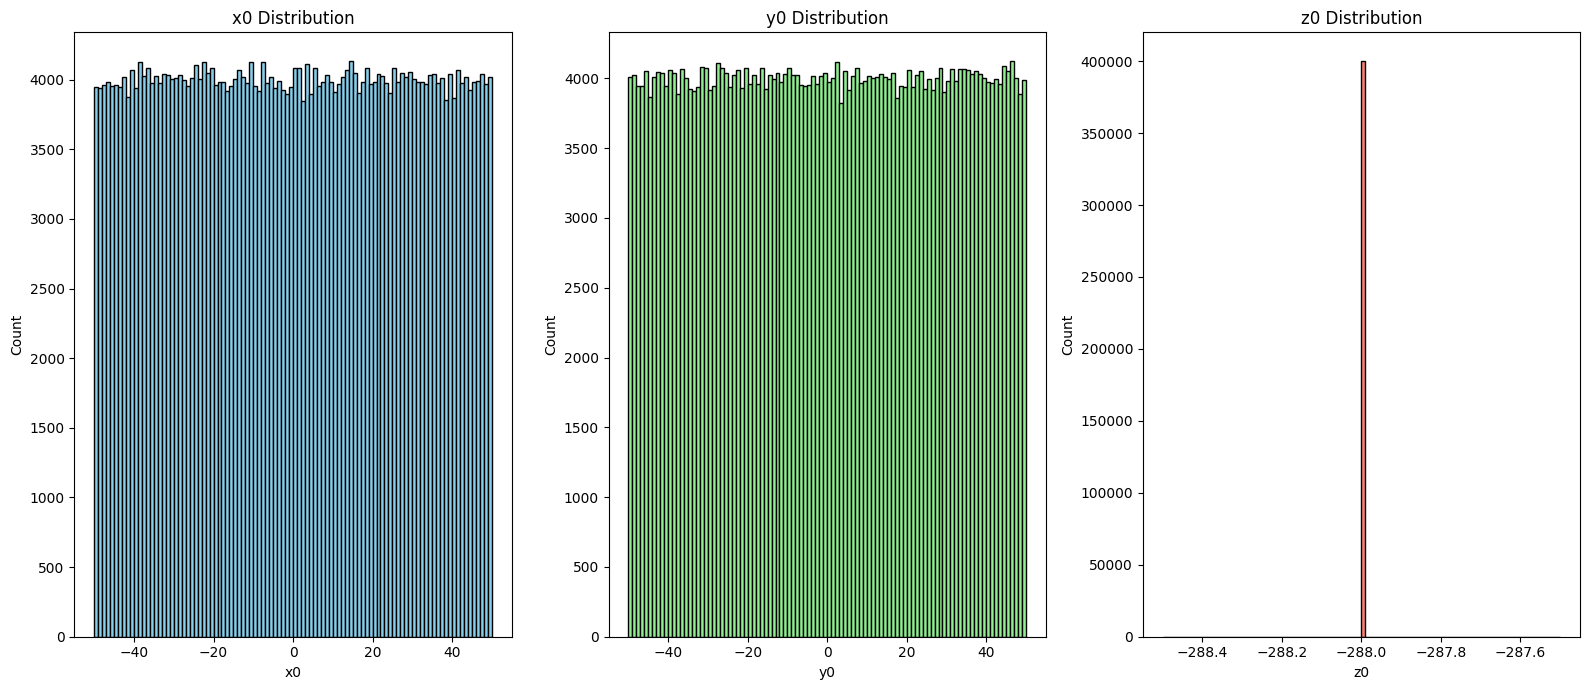

In [8]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(16, 7))

# Plot histograms
ax[0].hist(particle_data.x0, bins=100, color='skyblue', edgecolor='k')
ax[0].set_title('x0 Distribution')
ax[0].set_xlabel('x0')
ax[0].set_ylabel('Count')

ax[1].hist(particle_data.y0, bins=100, color='lightgreen', edgecolor='k')
ax[1].set_title('y0 Distribution')
ax[1].set_xlabel('y0')
ax[1].set_ylabel('Count')

ax[2].hist(particle_data.z0, bins=100, color='salmon', edgecolor='k')
ax[2].set_title('z0 Distribution')
ax[2].set_xlabel('z0')
ax[2].set_ylabel('Count')

# Layout adjustment
plt.tight_layout()
plt.show()


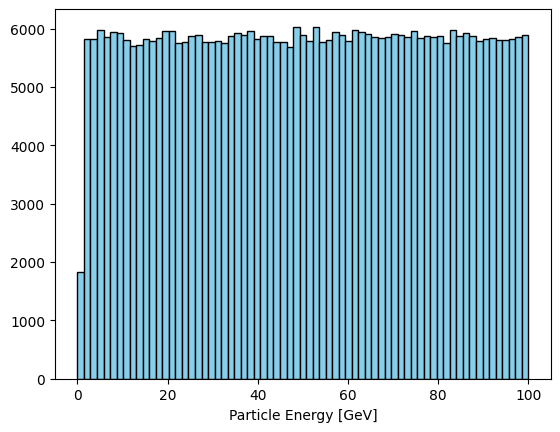

In [9]:
plt.hist(particle_data.energy, bins = np.linspace(0,100,70),  color='skyblue', edgecolor='k' )
plt.xlabel('Particle Energy [GeV]')
plt.show()

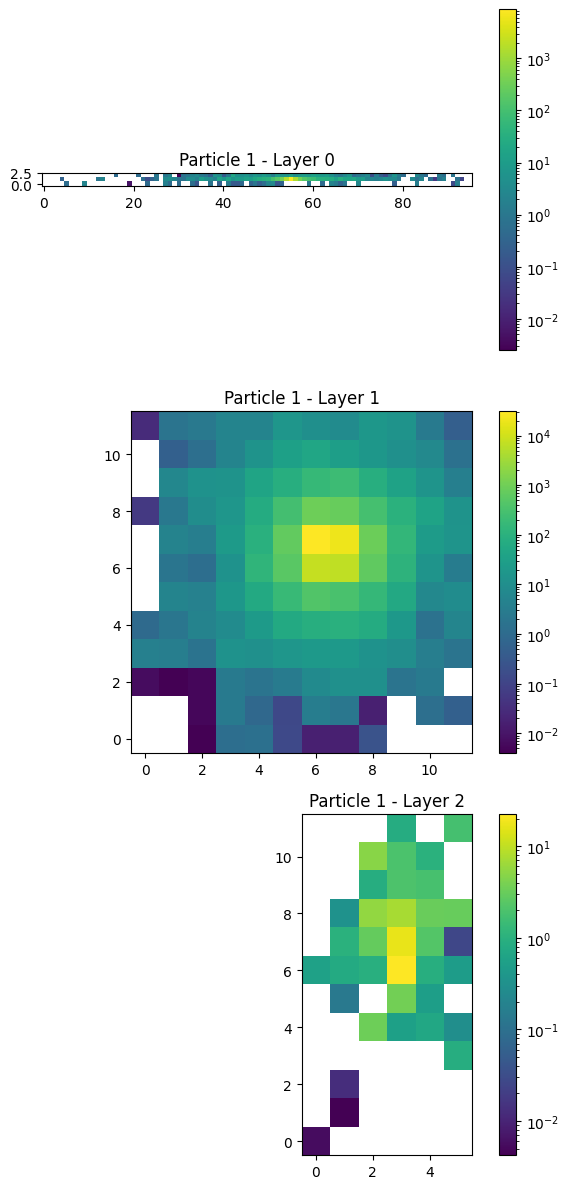

In [10]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(3, 1, figsize=(6, 12))  # 3 rows, 1 column

# Plot each layer for a single particle (index 0)
axes[0].imshow(particle_data.layer_0[0], interpolation='nearest', norm=LogNorm(), origin='lower')
axes[0].set_title('Particle 1 - Layer 0')
plt.colorbar(mappable=axes[0].images[0], ax=axes[0])

axes[1].imshow(particle_data.layer_1[0], interpolation='nearest', norm=LogNorm(), origin='lower')
axes[1].set_title('Particle 1 - Layer 1')
plt.colorbar(mappable=axes[1].images[0], ax=axes[1])

axes[2].imshow(particle_data.layer_2[0], interpolation='nearest', norm=LogNorm(), origin='lower')
axes[2].set_title('Particle 1 - Layer 2')
plt.colorbar(mappable=axes[2].images[0], ax=axes[2])

plt.tight_layout()
plt.show()


In [11]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

# Split indices
indices = np.arange(len(particle_data.energy))
train_idx, test_idx = train_test_split(indices, test_size=0.2, random_state=42)

# Compute statistics
layer_0_flat = particle_data.layer_0[train_idx].flatten()
layer_1_flat = particle_data.layer_1[train_idx].flatten()
layer_2_flat = particle_data.layer_2[train_idx].flatten()
energy = particle_data.energy[train_idx]

stats = {
    'l0_mean': np.mean(layer_0_flat),
    'l0_std':  np.std(layer_0_flat),
    'l1_mean': np.mean(layer_1_flat),
    'l1_std':  np.std(layer_1_flat),
    'l2_mean': np.mean(layer_2_flat),
    'l2_std':  np.std(layer_2_flat),
    'energy_mean': np.mean(energy),
    'energy_std':  np.std(energy),
}

# Print stats
print("Statistics for training set:")
for key, value in stats.items():
    print(f"{key}: {value:.2f}")

# Create raw and scaled feature dictionaries
raw_features = {
    'Layer 0': layer_0_flat,
    'Layer 1': layer_1_flat,
    'Layer 2': layer_2_flat,
    'Energy': energy
}

scaled_features = {
    'Layer 0': (layer_0_flat - stats['l0_mean']) / stats['l0_std'],
    'Layer 1': (layer_1_flat - stats['l1_mean']) / stats['l1_std'],
    'Layer 2': (layer_2_flat - stats['l2_mean']) / stats['l2_std'],
    'Energy': (energy - stats['energy_mean']) / stats['energy_std']
}

Statistics for training set:
l0_mean: 27.99
l0_std: 317.34
l1_mean: 291.79
l1_std: 2620.88
l2_mean: 1.24
l2_std: 7.09
energy_mean: 50.50
energy_std: 28.58


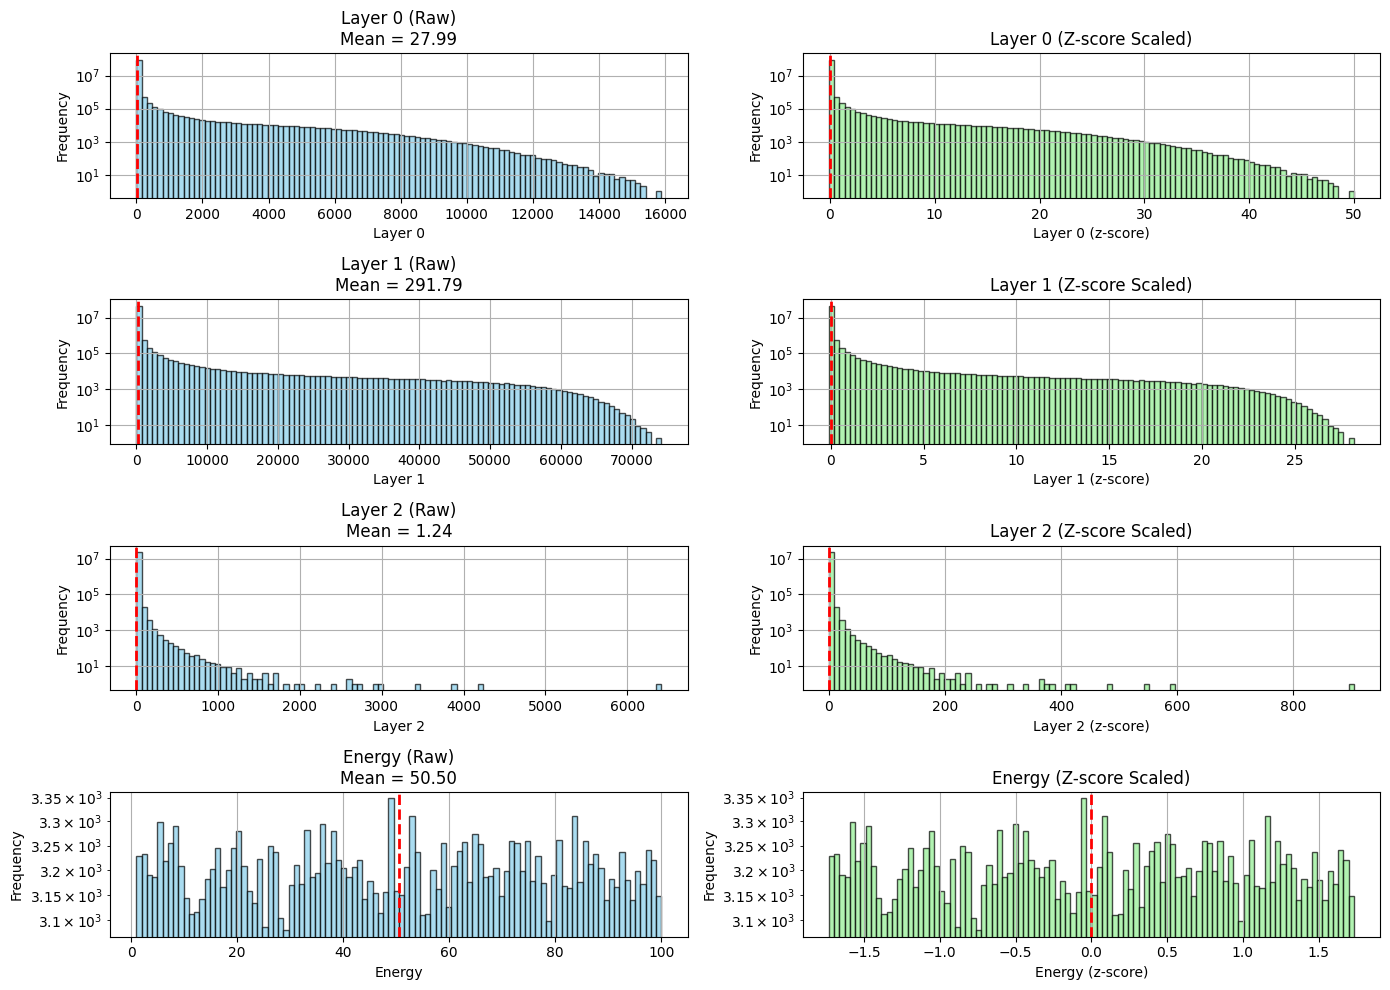

In [12]:
# Plot original and scaled histograms
plt.figure(figsize=(14, 10))
for i, key in enumerate(raw_features.keys()):
    # Raw plot
    plt.subplot(4, 2, i*2 + 1)
    plt.hist(raw_features[key], bins=100, color='skyblue', edgecolor='k', alpha=0.7)
    mean_val = np.mean(raw_features[key])
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'{key} (Raw)\nMean = {mean_val:.2f}')
    plt.xlabel(key)
    plt.yscale('log')
    plt.ylabel('Frequency')
    plt.grid(True)

    # Z-score plot
    plt.subplot(4, 2, i*2 + 2)
    plt.hist(scaled_features[key], bins=100, color='lightgreen', edgecolor='k', alpha=0.7)
    plt.axvline(0, color='red', linestyle='dashed', linewidth=2)
    plt.title(f'{key} (Z-score Scaled)')
    plt.xlabel(f'{key} (z-score)')
    plt.yscale('log')
    plt.ylabel('Frequency')
    plt.grid(True)

plt.tight_layout()
plt.show()

## CNN model 

![conv2d_scheme](./img/conv2d.png)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiInputCNN(nn.Module):
    def __init__(self):
        super(MultiInputCNN, self).__init__()

        # Branch A: (1, 3, 16)
        self.branch_a = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # → (8, 3, 16)
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),               # → (8, 1, 1) Reduces each feature map to a single value by averaging all its values.
            nn.Flatten()
        )

        # Branch B: (1, 12, 12)
        self.branch_b = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # Branch C: (1, 12, 6)
        self.branch_c = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten()
        )

        # Fully connected head
        self.fc = nn.Sequential(
            nn.Linear(8 * 3, 64),
            nn.ReLU(),
            nn.Linear(64, 1)  # regression output
        )

    def forward(self, x_a, x_b, x_c):
        out_a = self.branch_a(x_a)  # input: (B, 1, 3, 16)
        out_b = self.branch_b(x_b)  # input: (B, 1, 12, 12)
        out_c = self.branch_c(x_c)  # input: (B, 1, 12, 6)

        x = torch.cat([out_a, out_b, out_c], dim=1)
        return self.fc(x)


In [14]:
from torch.utils.data import Dataset

class ParticleDataset(Dataset):
    def __init__(self, particle_data, indices=None, normalize=True, stats=None):
        self.indices = indices if indices is not None else range(len(particle_data.energy))
        self.layer_0 = particle_data.layer_0[self.indices]
        self.layer_1 = particle_data.layer_1[self.indices]
        self.layer_2 = particle_data.layer_2[self.indices]
        
        self.energy  = particle_data.energy[self.indices]
        self.normalize = normalize
        self.stats = stats  # dict with mean/std for each layer

    def __len__(self):
        return len(self.energy)

    def __getitem__(self, idx):
        l0 = self.layer_0[idx]
        l1 = self.layer_1[idx]
        l2 = self.layer_2[idx]
        e = self.energy[idx]

        if self.normalize and self.stats:
            l0 = (l0 - self.stats['l0_mean']) / (self.stats['l0_std'] + 1e-6)
            l1 = (l1 - self.stats['l1_mean']) / (self.stats['l1_std'] + 1e-6)
            l2 = (l2 - self.stats['l2_mean']) / (self.stats['l2_std'] + 1e-6)
            e  = (e  - self.stats['energy_mean']) / (self.stats['energy_std'] + 1e-6)

        x_a = torch.tensor(l0, dtype=torch.float32).unsqueeze(0)  # (1, 3, 16)
        x_b = torch.tensor(l1, dtype=torch.float32).unsqueeze(0)  # (1, 12, 12)
        x_c = torch.tensor(l2, dtype=torch.float32).unsqueeze(0)  # (1, 12, 6)
        y   = torch.tensor(e, dtype=torch.float32).squeeze()

        return x_a, x_b, x_c, y

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


In [16]:
@torch.no_grad()
def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0

    for x_a, x_b, x_c, y in val_loader:
        x_a, x_b, x_c, y = x_a.to(device), x_b.to(device), x_c.to(device), y.to(device)
        outputs = model(x_a, x_b, x_c)
        loss = criterion(outputs, y.unsqueeze(1).float())
        total_loss += loss.item() * x_a.size(0)

    return total_loss / len(val_loader.dataset)


In [17]:
def train_model(model, train_loader, val_loader=None, epochs=10, lr=0.001, checkpoint_path='best_model.pth'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')


    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x_a, x_b, x_c, y in train_loader:
            x_a, x_b, x_c, y = x_a.to(device), x_b.to(device), x_c.to(device), y.to(device)

            optimizer.zero_grad()

            outputs = model(x_a, x_b, x_c)  # shape: (B, 1)
            loss = criterion(outputs, y.unsqueeze(1).float())  # ensure shapes match
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_a.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {epoch_train_loss:.4f}")

        # Validation
        if val_loader is not None:
            val_loss = evaluate_model(model, val_loader, criterion)
            val_losses.append(val_loss)
            print(f"  -  Val Loss: {val_loss:.4f}\n")
            # Checkpoint: save if improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), checkpoint_path)
                print("[Saved Best Model]\n")
        else:
            val_losses.append(None)

    return train_losses, val_losses


In [18]:
from torch.utils.data import DataLoader

# 4. Datasets
train_dataset = ParticleDataset(particle_data, indices=train_idx, stats=stats)
test_dataset  = ParticleDataset(particle_data, indices=test_idx,  stats=stats)

# 5. DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [19]:
model = MultiInputCNN()

train_losses, test_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    epochs=20,
    lr=0.001
)


Epoch 1/20 - Train Loss: 0.0091
  -  Val Loss: 0.0004

[Saved Best Model]

Epoch 2/20 - Train Loss: 0.0003
  -  Val Loss: 0.0002

[Saved Best Model]

Epoch 3/20 - Train Loss: 0.0003
  -  Val Loss: 0.0002

Epoch 4/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

Epoch 5/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

[Saved Best Model]

Epoch 6/20 - Train Loss: 0.0002
  -  Val Loss: 0.0015

Epoch 7/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

Epoch 8/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

Epoch 9/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

Epoch 10/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

[Saved Best Model]

Epoch 11/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

[Saved Best Model]

Epoch 12/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

Epoch 13/20 - Train Loss: 0.0002
  -  Val Loss: 0.0005

Epoch 14/20 - Train Loss: 0.0002
  -  Val Loss: 0.0003

Epoch 15/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

Epoch 16/20 - Train Loss: 0.0002
  -  Val Loss: 0.0002

[Saved Best M

In [20]:
# Uncomment the following lines to load the best model and evaluate it
# model = MultiInputCNN()
# model.load_state_dict(torch.load('best_model.pth'))
# model.to(device)
# model.eval()

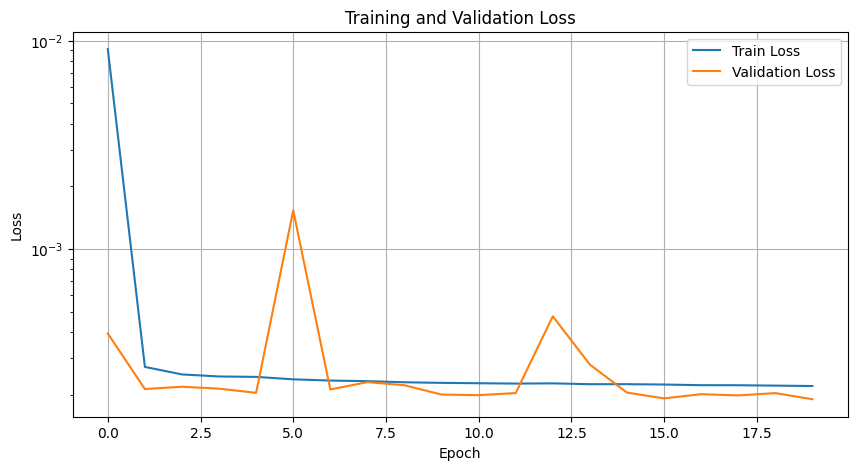

In [21]:

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
def scale_input_data(data, stats):
    return (data - stats['mean']) / (stats['std'] + 1e-6)
def unscale_output_data(data, stats):
    return data * (stats['std'] + 1e-6) + stats['mean']


In [23]:
# Assume you have numpy arrays for one sample
x_a_numpy = test_loader.dataset.layer_0 # shape (3,16)
x_b_numpy = test_loader.dataset.layer_1  # shape (12,12)
x_c_numpy = test_loader.dataset.layer_2  # shape (12,6)

# Scale the input data using the training statistics
x_a_numpy = scale_input_data(x_a_numpy, {'mean': stats['l0_mean'], 'std': stats['l0_std']})
x_b_numpy = scale_input_data(x_b_numpy, {'mean': stats['l1_mean'], 'std': stats['l1_std']})
x_c_numpy = scale_input_data(x_c_numpy, {'mean': stats['l2_mean'], 'std': stats['l2_std']})

# Convert to tensors and add batch and channel dims
x_a = torch.tensor(x_a_numpy, dtype=torch.float32).unsqueeze(1).to(device)  # (1,1,3,16)
x_b = torch.tensor(x_b_numpy, dtype=torch.float32).unsqueeze(1).to(device)  # (1,1,12,12)
x_c = torch.tensor(x_c_numpy, dtype=torch.float32).unsqueeze(1).to(device)  # (1,1,12,6)

with torch.no_grad():
    ypred = model(x_a, x_b, x_c).cpu().numpy()
# Unscale the output data using the training statistics
ypred = unscale_output_data(ypred, {'mean': stats['energy_mean'], 'std': stats['energy_std']})

In [24]:
ytest = test_loader.dataset.energy  # Get the first sample's energy

In [25]:
ypred = ypred.squeeze()
ytest = ytest.squeeze()

In [26]:
from sklearn.metrics import mean_squared_error

print("MSE: %.7f" % mean_squared_error(ytest, ypred))

MSE: 0.1554020


The **R² score** is a statistical metric that measures how well a regression model explains the **variance** in the target variable.

It is defined as:

$$
R^2 = 1 - \frac{SS_{\text{res}}}{SS_{\text{tot}}}
$$

Where:
- $SS_{\text{res}}$ = sum of squared residuals (errors)
- $ SS_{\text{tot}} = \sum (\bar{y} - y_i)^2 $= total sum of squares

---
R² tells you the proportion of variance in the target variable that is explained by the model.
  - An R² of **1.0** means perfect prediction.
  - An R² of **0.0** means the model does no better than predicting the mean.

In [27]:
import sklearn

par = np.polyfit(ypred.squeeze(), ytest.squeeze(),1)
r2score = sklearn.metrics.r2_score(par[0]*ypred.squeeze()+par[1], ytest.squeeze())

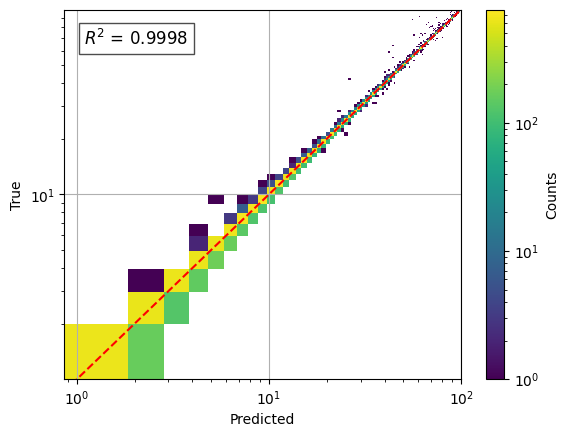

In [28]:
plt.hist2d(par[0]*ypred.squeeze()+par[1], ytest.squeeze(),bins = 100,norm = LogNorm())
plt.text(0.05, 0.95, f"$R^2$ = {r2score:.4f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
plt.plot([0,100],[0,100],'r--')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar(label='Counts')
plt.show()

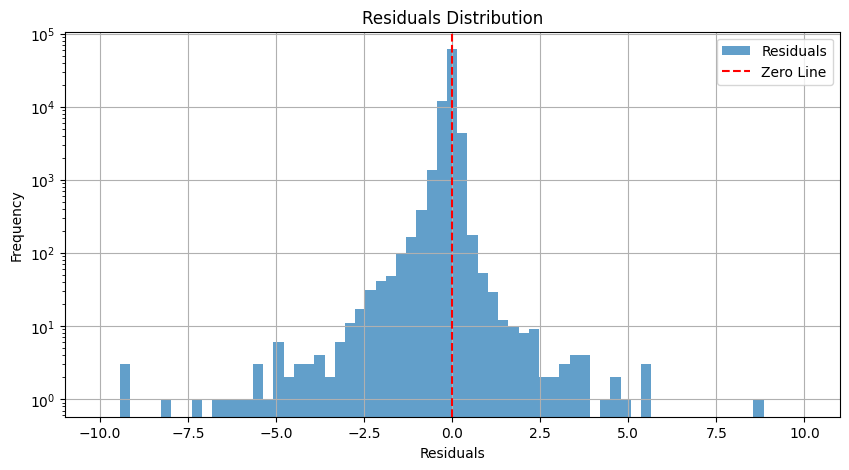

In [29]:
plt.figure(figsize=(10, 5))
plt.hist(ypred - ytest, bins=np.linspace(-10,10,70), alpha=0.7, label='Residuals')
plt.axvline(0, color='red', linestyle='--', label='Zero Line')
plt.yscale('log')

plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.legend()
plt.grid(True)

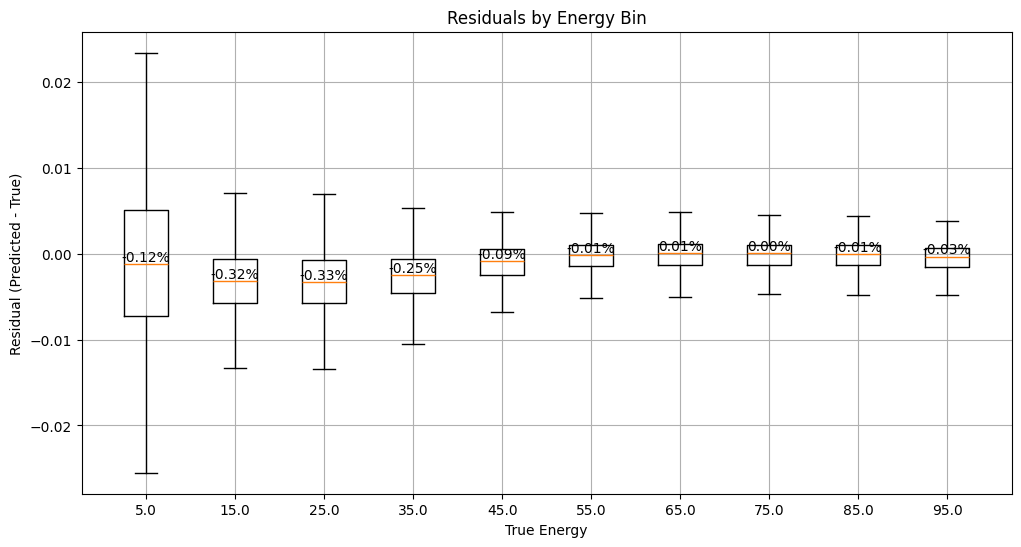

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Assuming these are unnormalized (original units):
# y_true and y_pred: shape (N,)
residuals = ypred - ytest
#compute relative error
RError = residuals / ytest  # relative error

# Define energy bins
# bins = np.linspace(ytest.min(), ytest.max(), num=10)  # e.g., 10 bins
bins = np.linspace(0, 100, num=11)  # e.g., 10 bins
bin_indices = np.digitize(ytest, bins)

# Create DataFrame for easy grouping
df = pd.DataFrame({
    'Energy': ytest,
    'RError': RError,
    'Bin': bin_indices
})

# Group by bin
bin_centers = 0.5 * (bins[:-1] + bins[1:])
residuals_by_bin = [df[df['Bin'] == i]['RError'] for i in range(1, len(bins))]

# Plot
plt.figure(figsize=(12, 6))
plt.boxplot(residuals_by_bin, positions=bin_centers, widths=5, 
            showfliers=False # to remvoe outliers
            
            )
#print text over each box to show the mean value
for i, res in enumerate(residuals_by_bin):
    mean_res = res.median()
    plt.text(bin_centers[i], mean_res, f'{mean_res *100:.2f}%', ha='center', va='bottom')
plt.xlabel('True Energy')
plt.ylabel('Residual (Predicted - True)')
plt.title('Residuals by Energy Bin')
plt.grid(True)
plt.show()



## Time to Excercise
Try to train a particle classificator using the 3 dataset above.